## Imagen3 Image Generation - Image Size

### Install Vertex AI SDK for Python


In [ ]:
%pip install --upgrade --user google-cloud-aiplatform

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


In [ ]:
PROJECT_ID = "PROJECT_ID"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [12]:
from vertexai.preview.vision_models import (
    Image,
    ImageGenerationModel,
    MaskReferenceImage,
    RawReferenceImage,
)

### Define a helper function

In [11]:
import typing

import IPython.display
from PIL import Image as PIL_Image

import matplotlib.pyplot as plt


def display_image(
    image, ratio
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    
    image_width, image_height = pil_image.size
    parts = ratio.split(":")
    ratio_w = int(parts[0])
    ratio_h = (image_height * ratio_w) / image_width
    print(f"generated image size : {image_width} x {image_height},  calculated ratio : {ratio_w} : {ratio_h}")
    
    IPython.display.display(pil_image)

### Load the image generation models

Imagen 3: `imagen-3.0-generate-001`

In [5]:
generation_model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")

In [14]:
import matplotlib.pyplot as plt

def generate_image(prompt: str, ratio: str) -> Image:
    # Imagen 3 image generation
    image = generation_model.generate_images(
        prompt=prompt,
        number_of_images=1,
        aspect_ratio=ratio,
        safety_filter_level="block_some",
        person_generation="dont_allow",
    )
    display_image(image[0], ratio)    
    return image[0]


In [19]:
import io
def get_bytes_from_pil(image: PIL_Image) -> bytes:
    byte_io_png = io.BytesIO()
    image.save(byte_io_png, "PNG")
    return byte_io_png.getvalue()

def pad_to_target_size(
    source_image,
    target_size=(1536, 1536),
    mode="RGB",
    vertical_offset_ratio=0,
    horizontal_offset_ratio=0,
    fill_val=255,
):
    orig_image_size_w, orig_image_size_h = source_image.size
    target_size_w, target_size_h = target_size

    insert_pt_x = (target_size_w - orig_image_size_w) // 2 + int(
        horizontal_offset_ratio * target_size_w
    )
    insert_pt_y = (target_size_h - orig_image_size_h) // 2 + int(
        vertical_offset_ratio * target_size_h
    )
    insert_pt_x = min(insert_pt_x, target_size_w - orig_image_size_w)
    insert_pt_y = min(insert_pt_y, target_size_h - orig_image_size_h)

    if mode == "RGB":
        source_image_padded = PIL_Image.new(
            mode, target_size, color=(fill_val, fill_val, fill_val)
        )
    elif mode == "L":
        source_image_padded = PIL_Image.new(mode, target_size, color=(fill_val))
    else:
        raise ValueError("source image mode must be RGB or L.")

    source_image_padded.paste(source_image, (insert_pt_x, insert_pt_y))
    return source_image_padded

def pad_image_and_mask(
    image_vertex: Image,
    mask_vertex: Image,
    target_size,
    vertical_offset_ratio,
    horizontal_offset_ratio,
):
    image_vertex.thumbnail(target_size)
    mask_vertex.thumbnail(target_size)

    image_vertex = pad_to_target_size(
        image_vertex,
        target_size=target_size,
        mode="RGB",
        vertical_offset_ratio=vertical_offset_ratio,
        horizontal_offset_ratio=horizontal_offset_ratio,
        fill_val=0,
    )
    mask_vertex = pad_to_target_size(
        mask_vertex,
        target_size=target_size,
        mode="L",
        vertical_offset_ratio=vertical_offset_ratio,
        horizontal_offset_ratio=horizontal_offset_ratio,
        fill_val=255,
    )
    return image_vertex, mask_vertex

def outpaint_image(original_image) -> None:
    edit_model = ImageGenerationModel.from_pretrained("imagen-3.0-capability-001")

    mask = PIL_Image.new("L", original_image._pil_image.size, 0)
    target_size = (1408, 792)
    
    image_pil_outpaint, mask_pil_outpaint = pad_image_and_mask(
        original_image._pil_image,
        mask,
        target_size,
        0,
        0,
    )

    raw_ref_image = RawReferenceImage(
        image=get_bytes_from_pil(image_pil_outpaint), reference_id=0
    )
    mask_ref_image = MaskReferenceImage(
        reference_id=1,
        image=get_bytes_from_pil(mask_pil_outpaint),
        mask_mode="user_provided",
        dilation=0.03,
    )
    prompt = "a chandelier hanging from the ceiling"
    edited_image = edit_model.edit_image(
        prompt=prompt,
        edit_mode="outpainting",
        reference_images=[raw_ref_image, mask_ref_image],
        number_of_images=1,
        safety_filter_level="block_some",
        person_generation="allow_adult",
    )
    display_image(edited_image[0], "16:9")

- 16:9 이미지 생성 - 1408x768
- 실제 ratio = 16:8.72

generated image size : 1408 x 768,  calculated ratio : 16 : 8.727272727272727


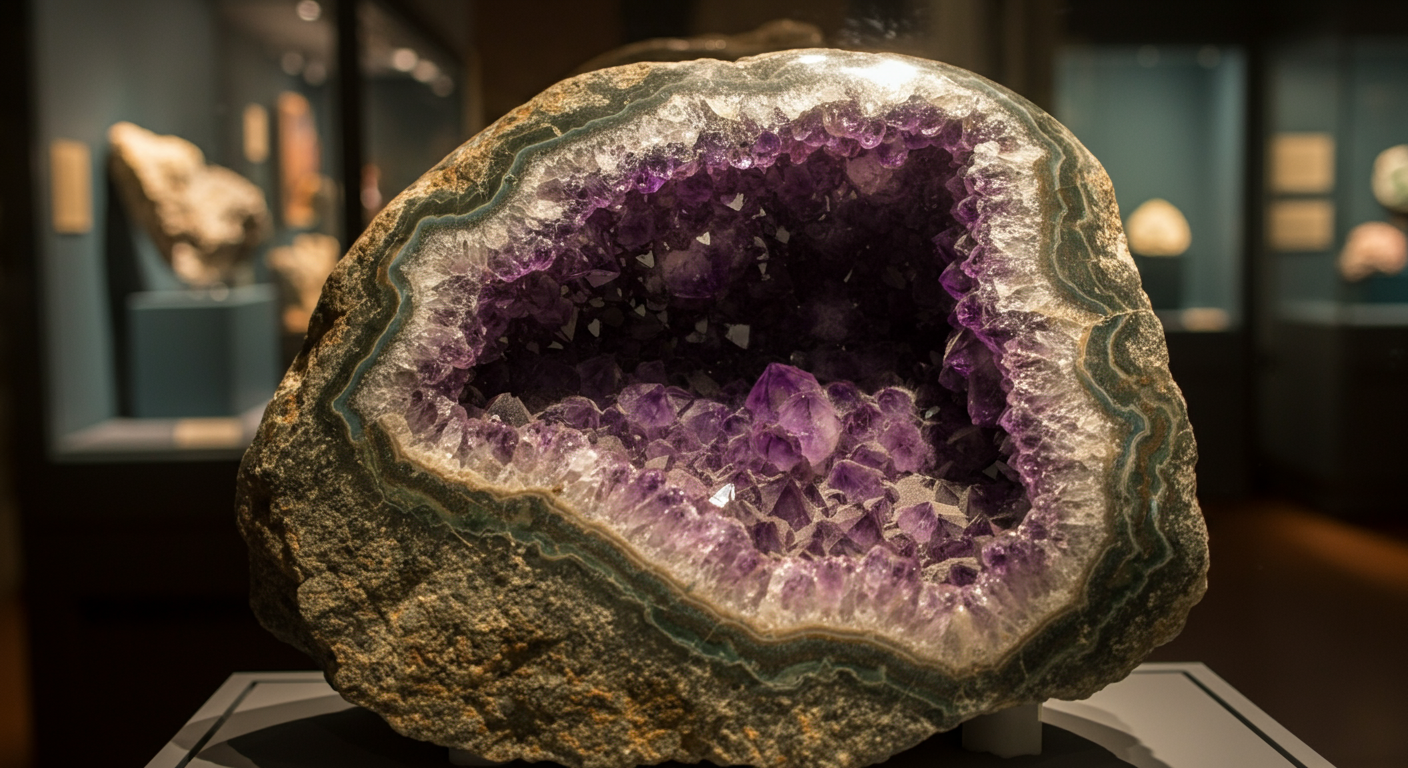

In [21]:
prompt = """
a photorealistic image of the inside of an amethyst crystal on display in a museum
"""
gen_image = generate_image(prompt, "16:9")


- 16:9 = 1408x792로 Outpainting

generated image size : 1408 x 792,  calculated ratio : 16 : 9.0


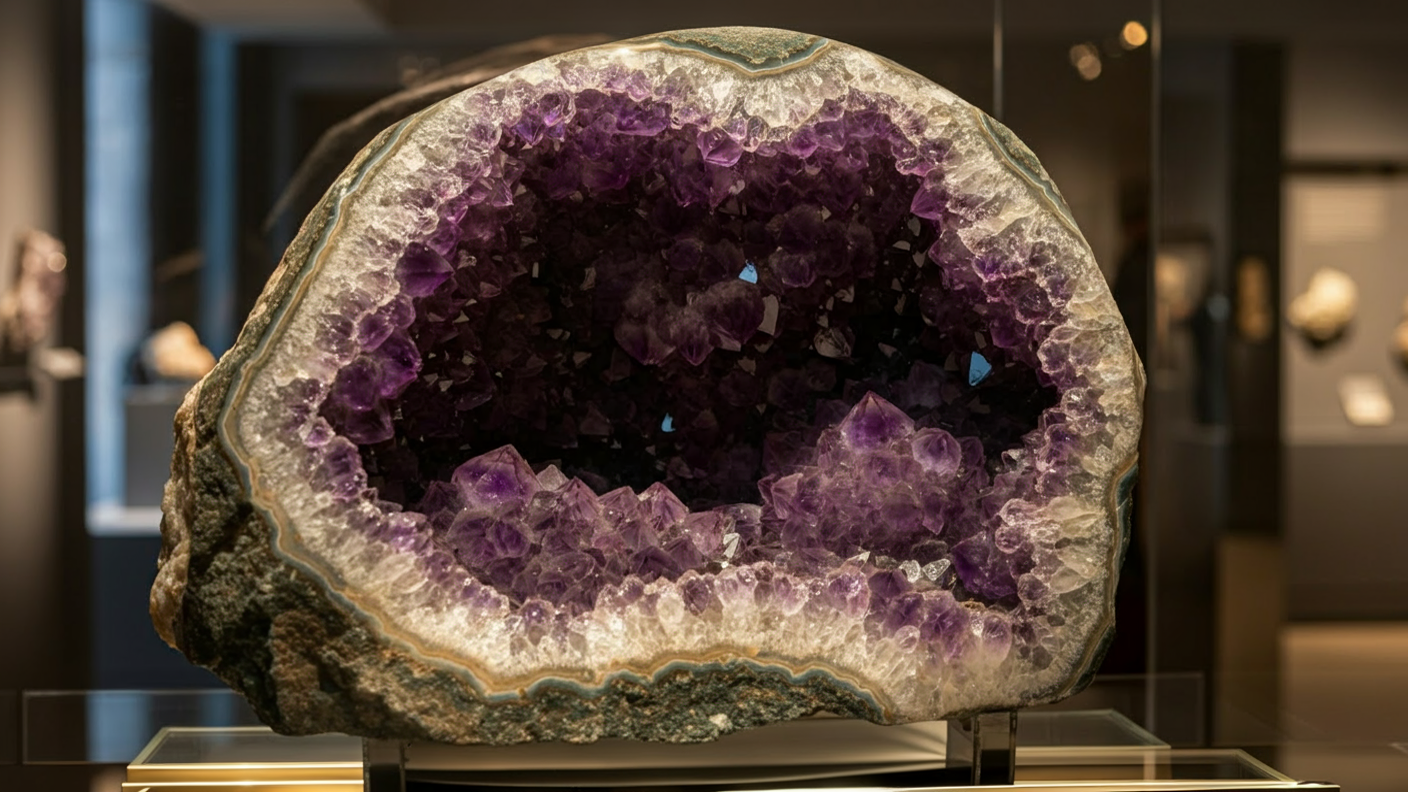

In [20]:
outpaint_image(gen_image)